<a href="https://colab.research.google.com/github/elisasanzani/Software_and_Computing_Project/blob/main/XGBoost_RadiativeMuonCapture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XGBoost RMC classification**

Preliminary setup

In [1]:
import numpy as np
import os
import xgboost as xgb
import time

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split

np.random.seed() # shuffle random seed generator

!nvidia-smi

Tue Aug 16 06:54:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import data from GitHub

In [2]:
!wget https://raw.githubusercontent.com/elisasanzani/Software_and_Computing_Project/main/data-XGBoost/mnbs_etrn.npy -O bkg_etrn.npy
!wget https://raw.githubusercontent.com/elisasanzani/Software_and_Computing_Project/main/data-XGBoost/signal_etrn.npy -O signal_etrn.npy


--2022-08-16 06:54:35--  https://raw.githubusercontent.com/elisasanzani/Software_and_Computing_Project/main/data-XGBoost/mnbs_etrn.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36304 (35K) [application/octet-stream]
Saving to: ‘bkg_etrn.npy’

bkg_etrn.npy        100%[===================>]  35.45K  --.-KB/s    in 0.003s  

2022-08-16 06:54:35 (12.7 MB/s) - ‘bkg_etrn.npy’ saved [36304/36304]

--2022-08-16 06:54:35--  https://raw.githubusercontent.com/elisasanzani/Software_and_Computing_Project/main/data-XGBoost/signal_etrn.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP r

Data visualization

In [3]:
#Loading data
signal_numpy_data = np.load("signal_etrn.npy")
bkg_numpy_data = np.load("bkg_etrn.npy")

#Preparing save directory for plots
images_dir = './images_Classifiers'
if not os.path.isdir(images_dir):
    os.makedirs(images_dir)

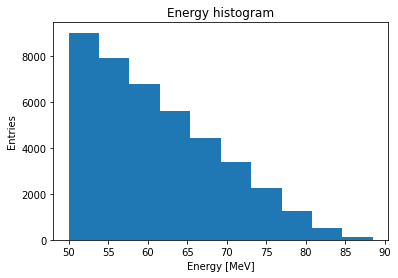

In [4]:
fig = plt.figure()
plt.hist(signal_numpy_data[:, 0])
plt.xlabel("Energy [MeV]")
plt.ylabel("Entries")
plt.title("Energy histogram")
plt_name = "data_energy.png"
filepath_imm = os.path.join(images_dir, plt_name)
fig.savefig(filepath_imm, facecolor='white',transparent=False )

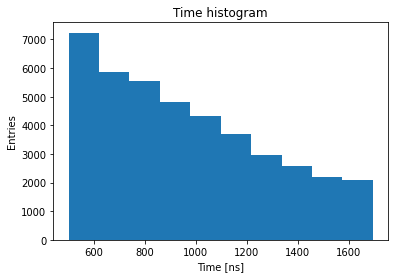

In [5]:
fig = plt.figure()
plt.hist(signal_numpy_data[:, 1])
plt.xlabel("Time [ns]")
plt.ylabel("Entries")
plt.title("Time histogram")
plt_name = "data_time.png"
filepath_imm = os.path.join(images_dir, plt_name)
fig.savefig(filepath_imm, facecolor='white',transparent=False )

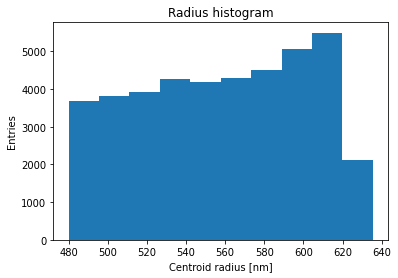

In [6]:
fig = plt.figure()
plt.hist(signal_numpy_data[:, 2])
plt.xlabel("Centroid radius [nm]")
plt.ylabel("Entries")
plt.title("Radius histogram")
plt_name = "data_radius.png"
filepath_imm = os.path.join(images_dir, plt_name)
fig.savefig(filepath_imm, facecolor='white',transparent=False )

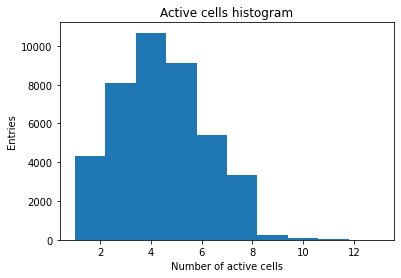

In [7]:
fig = plt.figure() 
plt.hist(signal_numpy_data[:, 3])
plt.xlabel("Number of active cells")
plt.ylabel("Entries")
plt.title("Active cells histogram")
plt_name = "data_cells.png"
filepath_imm = os.path.join(images_dir, plt_name)
fig.savefig(filepath_imm, facecolor='white',transparent=False)

Dataset split in train and test

In [8]:
#Features array
X = np.concatenate((signal_numpy_data, bkg_numpy_data))

#Labels array (1 signal, 0 bkg)
Y = np.concatenate((np.ones(len(signal_numpy_data)), np.zeros(len(bkg_numpy_data))))

#Dataset re-weighted to match real Mu2e statistics
signal_weight = 330/150e3 * 100
mnbs_weight = 1.3/5.25 * 100

#Weights
W = np.concatenate([ np.ones((len(signal_numpy_data)))*signal_weight, np.ones((len(bkg_numpy_data)))*mnbs_weight ])


print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

train_to_test_ratio = 0.8

X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(
    X, Y, W,
    train_size = train_to_test_ratio,
    test_size = 1.0 - train_to_test_ratio
)

X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(
    X_train, Y_train, W_train,
    train_size = train_to_test_ratio,
    test_size = 1.0 - train_to_test_ratio
)


X shape: (42504, 4)
Y shape: (42504,)


In [9]:
#Package to make DT plot
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 934 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.7-py3-none-any.whl size=68151 sha256=5f8ea4b2b1ef0de3160e8ce832fd538ccf691971d6feceabf51038118408ae26
  Stored in directory: /root/.cache/pip/wheels/bf/ba/9f/87c689d8d3c2916793f2dccc57d3dc3b283e0ccf8cb4ca4cad
Successfully built dtreeviz


Classifiers imported from Scikit-Learn and used on data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished




 ==> RandomForestClassifier
 ======> AUPRC: 0.9392


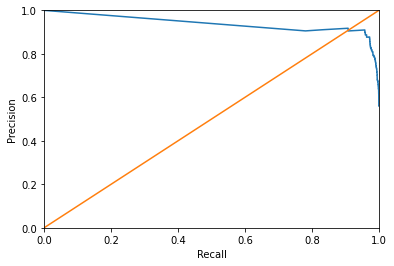

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished




 ==> ExtraTreesClassifier
 ======> AUPRC: 0.9524


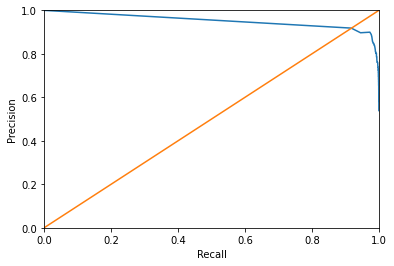



 ==> AdaBoostClassifier
 ======> AUPRC: 0.9258


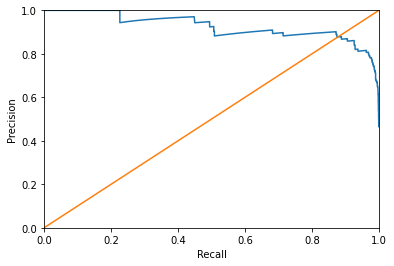



 ==> HistGradientBoostingClassifier
 ======> AUPRC: 0.9249


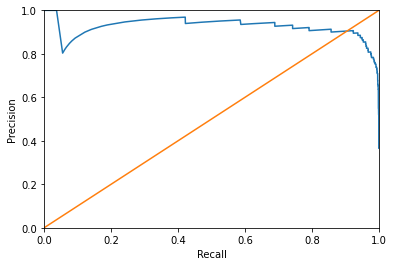

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))




 ==> DecisionTreeClassifier
 ======> AUPRC: 0.8197


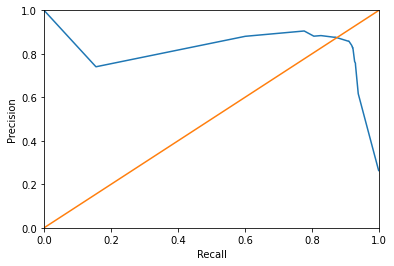

In [10]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from dtreeviz.trees import *

#created dict with the classifiers for easy hnadling
clf_dict = {
    RandomForestClassifier: dict(min_samples_split=10, n_estimators=200, warm_start=True, verbose=1),
    ExtraTreesClassifier: dict(n_estimators=200, verbose=1),
    AdaBoostClassifier: dict(n_estimators=200),
    HistGradientBoostingClassifier: dict(max_iter=200),
    DecisionTreeClassifier: dict(max_depth=5),
}

for clf in clf_dict:
  instance = clf(**clf_dict[clf])

  instance.fit(X_train, Y_train, sample_weight=W_train)

  probs = instance.predict_proba(X_test)[:, 1]

  if isinstance(instance, DecisionTreeClassifier):

    viz = dtreeviz(instance, X_test, Y_test,
                    target_name="target",
                    feature_names=["E", "T", "R", "C"],
                    class_names=["S", "B"] )

    viz.save("decision_tree.svg")

  prec, recall, thres = precision_recall_curve(Y_test, probs, sample_weight=W_test)
  
  instance_text = f"{instance}"
  clf_name = instance_text.partition("(")[0]
  print("\n\n ==>", clf_name)
  print(f" ======> AUPRC: {auc(recall, prec):0.4f}")
  
  fig = plt.figure()
  plt.plot(recall, prec)
  plt.plot([0, 1], [0, 1])
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.ylabel("Precision")
  plt.xlabel("Recall")
  plt_name = f"pr_{clf_name}.png"
  filepath_imm = os.path.join(images_dir, plt_name)
  fig.savefig(filepath_imm, facecolor='white',transparent=False )
  plt.show()


**XGBoost implementation**

In [11]:
time_start = time.time()

#convert the dataset into the XGBoost optimized data structure DMatrix
xg_train = xgb.DMatrix(X_train, label=Y_train, weight=W_train) #train
xg_test = xgb.DMatrix(X_test, label=Y_test, weight=W_test)     #test
xg_val = xgb.DMatrix(X_val, label=Y_val, weight=W_val)         #validation

param = {
    # use softmax multi-class classification
    # scale weight of positive examples
    'objective': 'binary:logistic',
    'n_estimators': 20,
    'max_depth': 5,
    'silent': 0,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    "eval_metric": [
      "aucpr",
    ]
}

# watchlist allows to monitor the evaluation result on all data in the list 
watchlist = [(xg_train, 'train'), (xg_val, 'val')]
num_round = 50

bst = xgb.train(param, xg_train, num_round, watchlist)

print("Elapsed time [s]: ", time.time() - time_start)

[0]	train-aucpr:0.930844	val-aucpr:0.801883
[1]	train-aucpr:0.955847	val-aucpr:0.85562
[2]	train-aucpr:0.972451	val-aucpr:0.874049
[3]	train-aucpr:0.974539	val-aucpr:0.920485
[4]	train-aucpr:0.977498	val-aucpr:0.935191
[5]	train-aucpr:0.98199	val-aucpr:0.936493
[6]	train-aucpr:0.983617	val-aucpr:0.93557
[7]	train-aucpr:0.984989	val-aucpr:0.927221
[8]	train-aucpr:0.986179	val-aucpr:0.934777
[9]	train-aucpr:0.986929	val-aucpr:0.930813
[10]	train-aucpr:0.988121	val-aucpr:0.93225
[11]	train-aucpr:0.988662	val-aucpr:0.932093
[12]	train-aucpr:0.988986	val-aucpr:0.931041
[13]	train-aucpr:0.989417	val-aucpr:0.932255
[14]	train-aucpr:0.989755	val-aucpr:0.933293
[15]	train-aucpr:0.990369	val-aucpr:0.937773
[16]	train-aucpr:0.990791	val-aucpr:0.937662
[17]	train-aucpr:0.991263	val-aucpr:0.940341
[18]	train-aucpr:0.992146	val-aucpr:0.938992
[19]	train-aucpr:0.992497	val-aucpr:0.939273
[20]	train-aucpr:0.993334	val-aucpr:0.940602
[21]	train-aucpr:0.993509	val-aucpr:0.937463
[22]	train-aucpr:0.99413



 ==> XGBoost
 ======> AUPRC: 0.9567


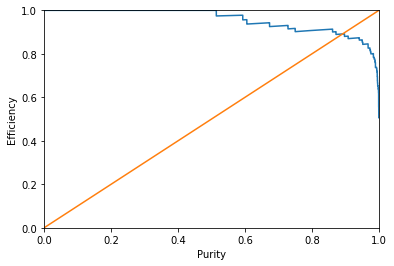

In [12]:
probs = bst.predict(xg_test)

prec, recall, thres = precision_recall_curve(Y_test, probs, sample_weight=W_test)


print("\n\n ==> XGBoost")
print(f" ======> AUPRC: {auc(recall, prec):0.4f}")

fig = plt.figure()
plt.plot(recall, prec)
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Purity")
plt.ylabel("Efficiency")
plt_name = "pr_XGBoost.png"
filepath_imm = os.path.join(images_dir, plt_name)
fig.savefig(filepath_imm, facecolor='white',transparent=False )

Plot the output tree

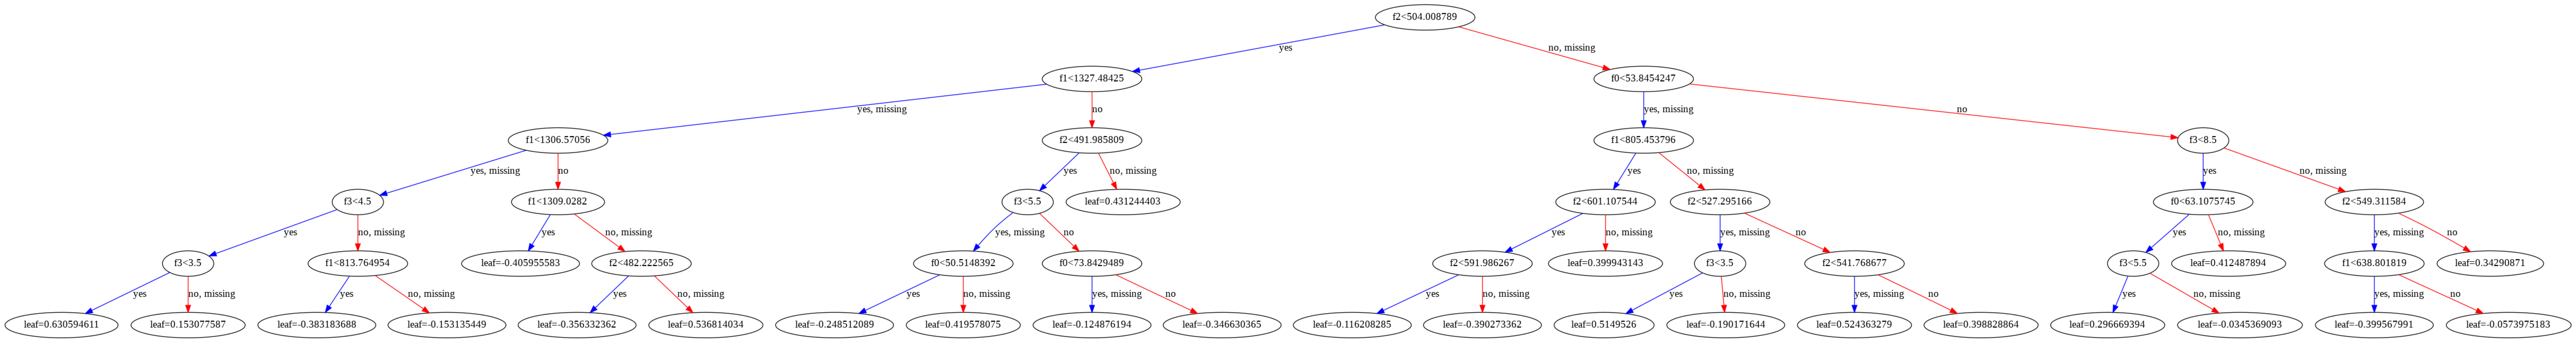

In [13]:
xgb.plot_tree(bst, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt_name = "tree_xgboost.png"
filepath_imm = os.path.join(images_dir, plt_name)
fig.savefig(filepath_imm, facecolor='white',transparent=False )

In [ ]:
#If executing with Colab, uncomment for a zoomed version
#xgb.to_graphviz(bst, num_trees=2)


In [ ]:
#Uncomment to save locally the plots shown in Colab

#from google.colab import files
#!zip -r images_Classifiers.zip images_Classifiers
#files.download('images_Classifiers.zip')